1. 점수별로 끊어서, 지표들의 변화를 살펴 가설 세워보기. 그리고 이 가설이 분포에 의존적인지 생각해보기(키와 몸무게는 그럴 수 있었음)

In [1]:
import wandb
wandb.login()
# 📦 분석 환경 셋업 및 CSV 파일 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
import os

# 👉 불러올 CSV 경로를 설정하세요
csv_path = "../datasets/DACON_Stress/train.csv"  # 예: "data/train.csv" 또는 "hand_data.csv"

# CSV 로드
df = pd.read_csv(csv_path)

# 간단한 확인
print(f"✅ 데이터 로드 완료: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()
df.dropna()

wandb: Currently logged in as: bgcho96 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ 데이터 로드 완료: 3000 rows, 18 columns


,ID,gender,age,height,weight,cholesterol,systolic_blood_pressure,diastolic_blood_pressure,glucose,bone_density,activity,smoke_status,medical_history,family_medical_history,sleep_pattern,edu_level,mean_working,stress_score
12,TRAIN_0012,F,32,160.00,69.84,216.29,124,100,114.40,1.36,moderate,ex-smoker,high blood pressure,high blood pressure,sleep difficulty,graduate degree,8.0,0.59
25,TRAIN_0025,F,39,163.05,94.85,223.32,155,92,135.58,0.87,moderate,ex-smoker,high blood pressure,high blood pressure,normal,bachelors degree,9.0,0.54
26,TRAIN_0026,M,53,170.80,83.19,228.00,162,89,149.90,0.87,moderate,current-smoker,high blood pressure,diabetes,normal,high school diploma,10.0,0.89
38,TRAIN_0038,M,42,175.87,108.00,236.10,140,95,123.40,1.25,moderate,ex-smoker,heart disease,diabetes,normal,bachelors degree,8.0,0.97
39,TRAIN_0039,F,39,155.80,61.30,242.55,115,105,122.29,1.09,light,current-smoker,diabetes,high blood pressure,normal,high school diploma,8.0,0.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2978,TRAIN_2978,F,63,164.28,68.46,232.70,171,98,146.09,0.78,moderate,ex-smoker,diabetes,diabetes,sleep difficulty,high school diploma,10.0,0.24
2982,TRAIN_2982,M,34,180.74,72.79,204.84,133,98,129.97,1.51,intense,ex-smoker,high blood pressure,diabetes,oversleeping,graduate degree,9.0,0.11
2985,TRAIN_2985,F,52,170.88,58.70,218.21,137,103,145.82,1.13,intense,current-smoker,heart disease,diabetes,oversleeping,bachelors degree,8.0,0.03
2993,TRAIN_2993,M,37,180.60,82.64,215.41,136,78,130.09,1.08,moderate,non-smoker,heart disease,high blood pressure,sleep difficulty,bachelors degree,7.0,0.08


In [2]:
import pandas as pd
import numpy as np

def analyze_by_stress_bins(df, stress_col='stress_score', bin_size=0.125):
    # 1. 구간 나누기
    bins = np.arange(0, 1.0001, bin_size)
    labels = [f"{round(b, 3)}~{round(b+bin_size, 3)}" for b in bins[:-1]]
    df['stress_bin'] = pd.cut(df[stress_col], bins=bins, labels=labels, include_lowest=True)

    # 2. 숫자형, 범주형 컬럼 나누기
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=[stress_col]).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # 3. 결과 저장용 dict
    results = {}

    for bin_label in labels:
        subset = df[df['stress_bin'] == bin_label]
        if subset.empty:
            continue

        bin_stats = {}

        # 숫자형 통계
        num_desc = subset[numeric_cols].describe().T[['mean', 'std', 'min', 'max']]
        bin_stats['numeric_summary'] = num_desc

        # 범주형 통계
        cat_summary = {}
        for col in categorical_cols:
            cat_summary[col] = (subset[col].value_counts(normalize=True) * 100).round(2)
        bin_stats['categorical_summary'] = cat_summary

        results[bin_label] = bin_stats

    return results

In [6]:
results = analyze_by_stress_bins(df)

# 특정 구간 예시 확인
example_bin = '0.375~0.5'
print("📊 Numeric Stats:")
print(results[example_bin]['numeric_summary'])
example_bin = '0.5~0.625'
print("📊 Numeric Stats:")
print(results[example_bin]['numeric_summary'])

print("\n📋 Categorical Breakdown:")
for col, dist in results[example_bin]['categorical_summary'].items():
    print(f"\n{col}:\n{dist}")

📊 Numeric Stats:
                                mean        std     min     max
age                        55.005181  20.240758   18.00   89.00
height                    168.171062   9.606431  147.24  190.68
weight                     71.923679  12.672961   40.51  108.68
cholesterol               233.487280  21.482942  171.03  296.09
systolic_blood_pressure   146.150259  16.452473  109.00  182.00
diastolic_blood_pressure   96.461140   9.880575   64.00  122.00
glucose                   126.775052  18.722256   82.77  181.09
bone_density                0.895130   0.439444   -0.12    1.92
mean_working                8.672199   1.808664    4.00   15.00
📊 Numeric Stats:
                                mean        std     min     max
age                        53.909836  21.047111   18.00   89.00
height                    169.027923   9.557710  144.44  193.71
weight                     73.222377  12.139949   47.56  108.31
cholesterol               234.949180  24.526397  169.88  304.63
systol

In [11]:
results['0.0~0.125']['numeric_summary']

,mean,std,min,max
age,51.990220,20.023024,17.00,89.00
height,168.915917,9.096818,148.71,193.21
weight,72.208386,13.142324,36.32,120.88
cholesterol,233.664425,24.924501,162.79,298.75
systolic_blood_pressure,145.078240,15.080137,109.00,185.00
diastolic_blood_pressure,95.444988,9.601753,67.00,119.00
glucose,126.100660,18.591035,78.68,174.87
bone_density,0.954059,0.430760,-0.11,1.82
mean_working,8.380623,1.274934,4.00,11.00


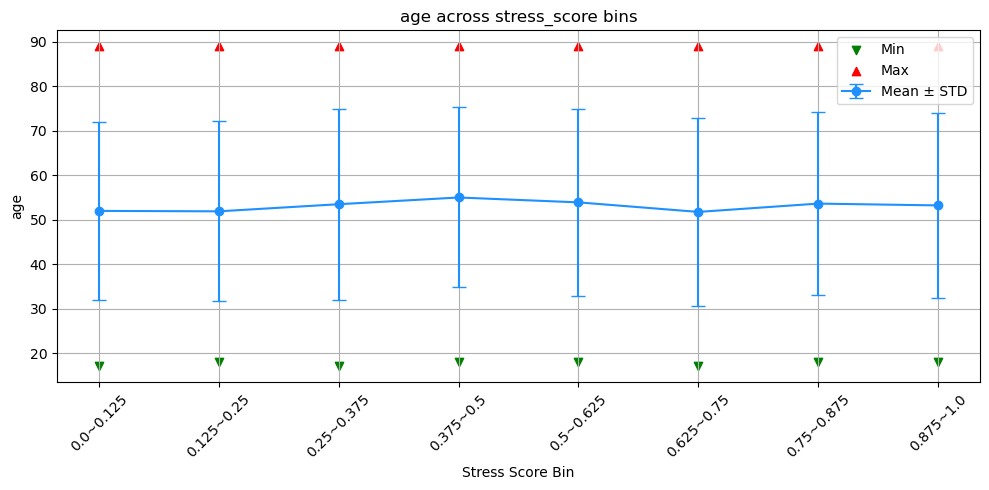

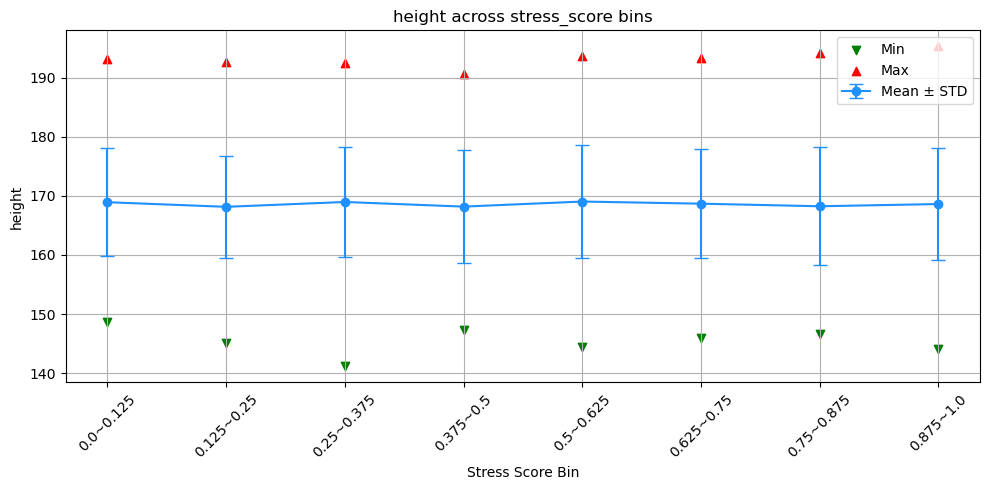

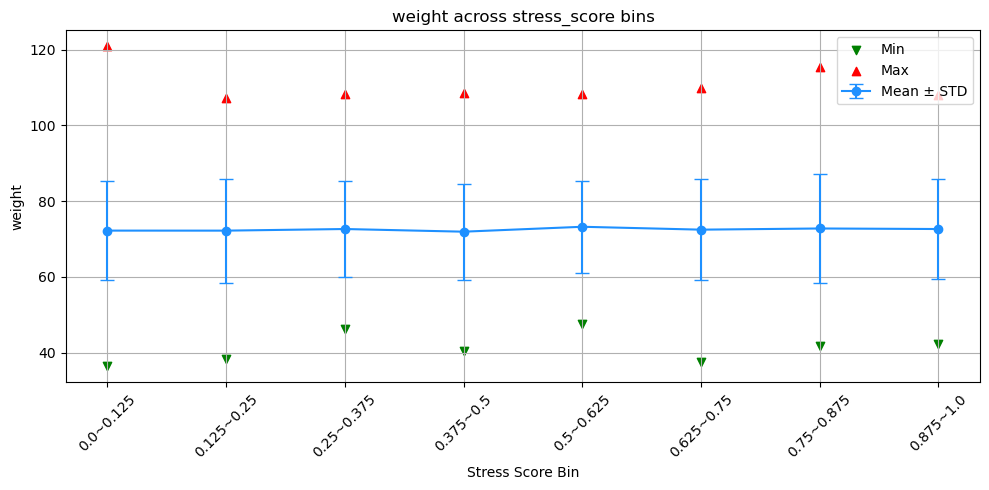

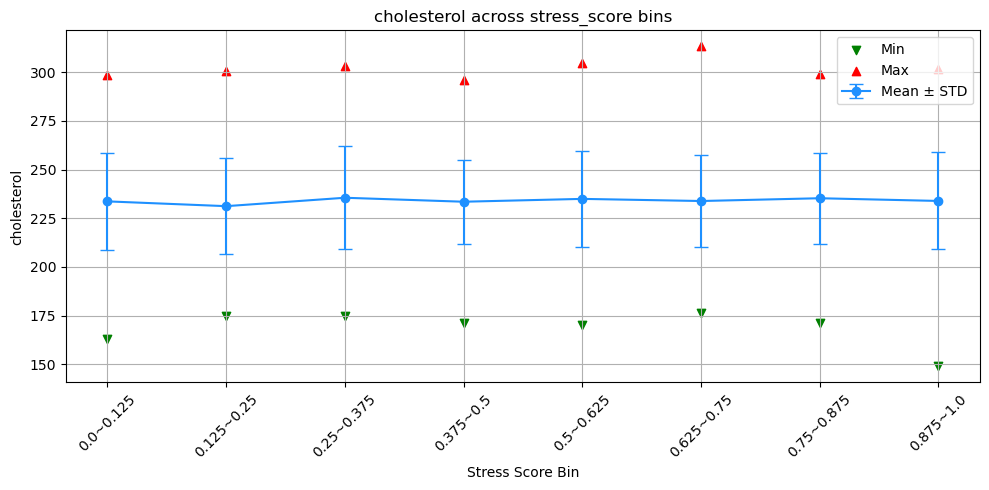

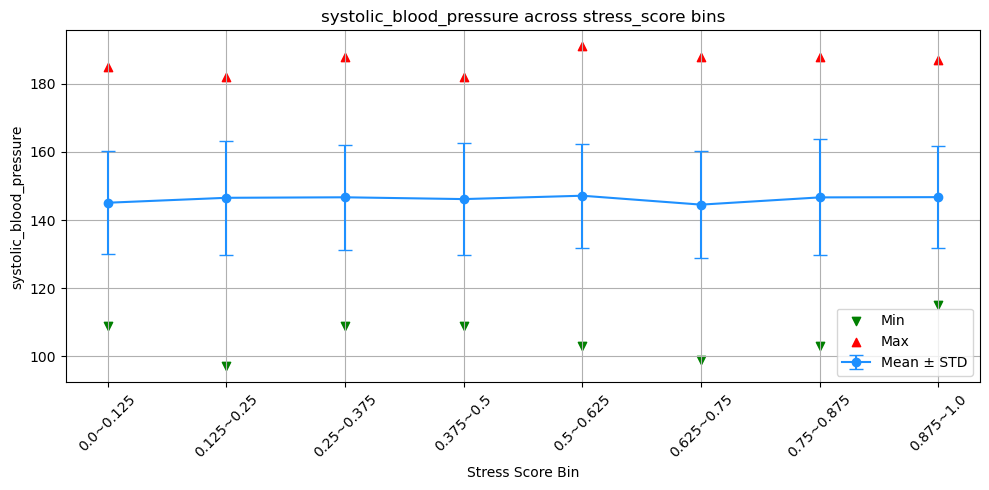

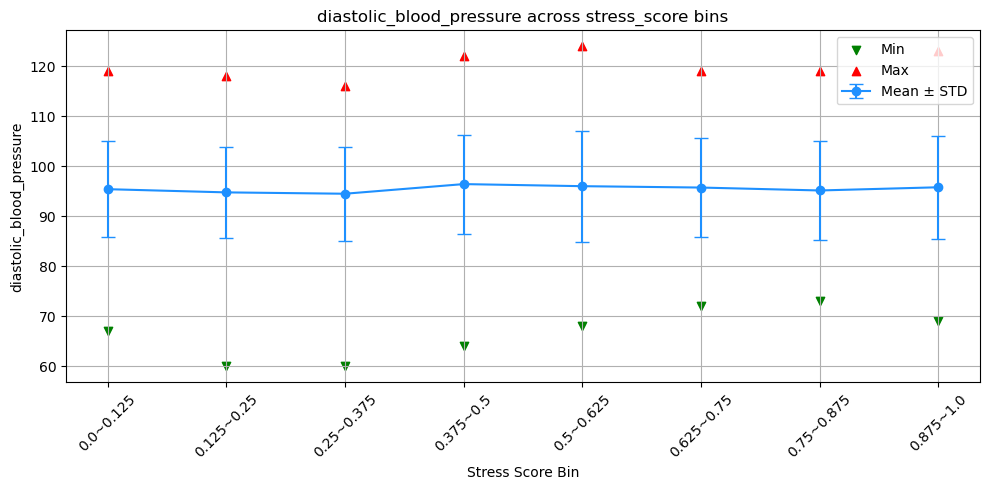

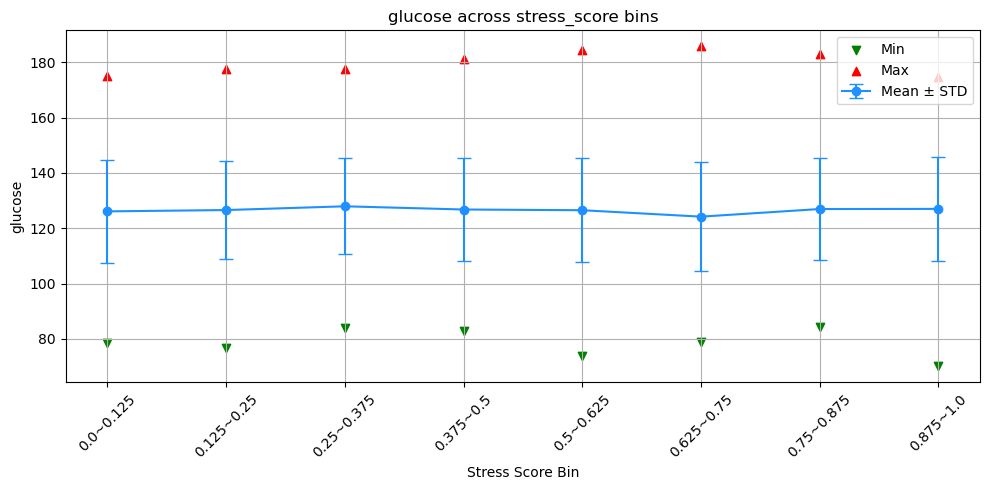

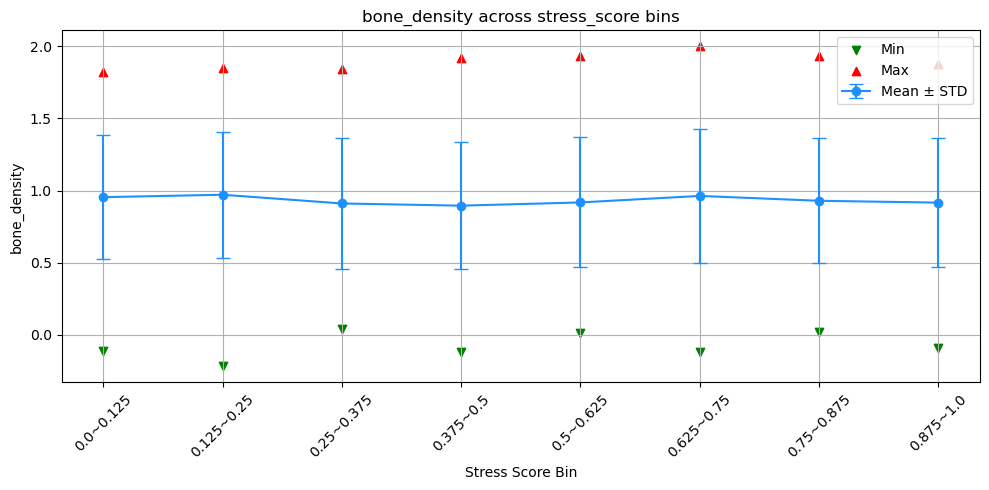

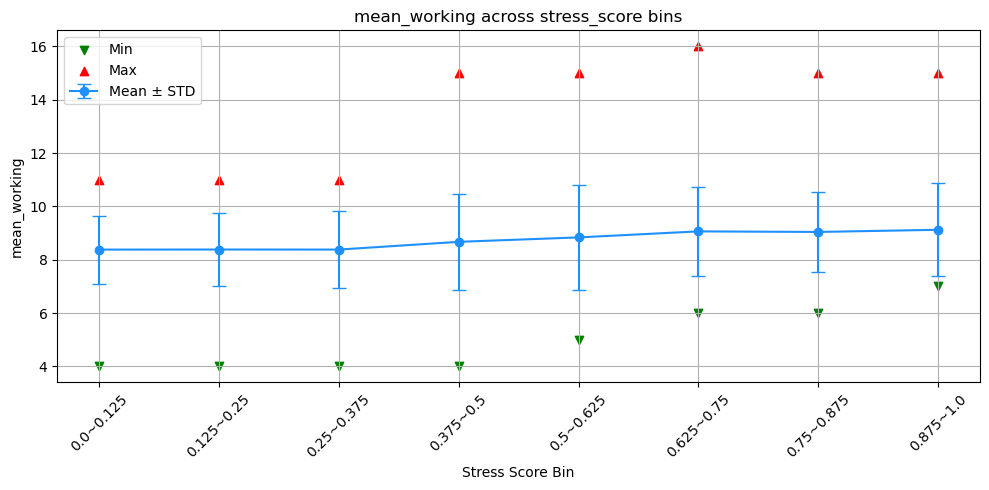

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# 파라미터: results 딕셔너리와 분석할 컬럼 리스트
def plot_candle_from_results(results_dict, numeric_columns):
    bins = list(results_dict.keys())  # 예: ['0.0~0.125', ..., '0.875~1.0']

    for col in numeric_columns:
        means, stds, mins, maxs = [], [], [], []

        for bin_label in bins:
            stats = results_dict[bin_label]['numeric_summary']
            means.append(stats.loc[col, 'mean'])
            stds.append(stats.loc[col, 'std'])
            mins.append(stats.loc[col, 'min'])
            maxs.append(stats.loc[col, 'max'])

        x = list(range(len(bins)))

        plt.figure(figsize=(10, 5))
        plt.errorbar(x, means, yerr=stds, fmt='o-', capsize=5, label='Mean ± STD', color='dodgerblue')
        plt.scatter(x, mins, marker='v', color='green', label='Min')
        plt.scatter(x, maxs, marker='^', color='red', label='Max')

        plt.xticks(ticks=x, labels=bins, rotation=45)
        plt.title(f'{col} across stress_score bins')
        plt.xlabel('Stress Score Bin')
        plt.ylabel(col)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# 예시 호출
numeric_cols = ['age', 'height', 'weight', 'cholesterol', 'systolic_blood_pressure', 
                'diastolic_blood_pressure', 'glucose', 'bone_density', 'mean_working']
plot_candle_from_results(results, numeric_cols)